In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold,GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, explained_variance_score
from sklearn.linear_model import Lasso,ElasticNet,ARDRegression
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
from time import time

In [5]:
outdir = "./lung_data/"
cancer = "Lung"

## TCGA+CCLE mRNA miRNA


In [7]:
mrna = pd.read_csv(outdir+cancer+'ranked_tcga_ccle_mrna.csv',index_col=0)
mirna = pd.read_csv(outdir+cancer+'ranked_tcga_ccle_mirna.csv',index_col=0)

In [8]:
# 使用 StandardScaler 进行 z-score 标准化
def standard(mrna,mirna):
    scaler = MinMaxScaler()
    mrna_scale = scaler.fit_transform(mrna)
    
    # # 使用 StandardScaler 进行 z-score 标准化
    scaler = MinMaxScaler()
    mirna_scale = scaler.fit_transform(mirna)
    
    mrna = pd.DataFrame(mrna_scale, columns=mrna.columns)
    mirna = pd.DataFrame(mirna_scale, columns=mirna.columns)
    return mrna,mirna

#划分训练集和测试集
def SplitData(mrna,mirna,split_size):
    x_train, x_test, y_train, y_test = train_test_split(mrna, mirna,test_size=split_size)
    return x_train, x_test, y_train, y_test

In [9]:
mrna,mirna = standard(mrna,mirna)
x_train, x_test, y_train, y_test = SplitData(mrna,mirna,split_size=0.1)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((604, 1741), (68, 1741), (604, 346), (68, 346))

In [12]:
def Build_Model(lr,n_estimators=100,max_depth=3):
    other_params = {'learning_rate': lr, 'n_estimators': n_estimators, 'max_depth': max_depth, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.3, 'colsample_bytree': 0.3, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 1}

    # 建立XGBoost模型 
    model = XGBRegressor(**other_params,tree_method="hist", device="cuda")
    return model

def Train_Model(model,x_train,y_train):
    t0 = time()
    # 训练模型
    model.fit(x_train, y_train)
    print(f"XGBoost fit done in {(time() - t0):.3f}s")
    y_ = model.predict(x_train)
    Fit_visual(y_train,y_,type="Train",cancer_type=cancer,color="lightblue")
    
    # 使用模型进行预测
    predictions = model.predict(x_test)
    Fit_visual(y_test,predictions,type="Test",cancer_type=cancer,color="lightgreen")
    # r2_score_xgb = r2_score(y_test, predictions)
    # print(f"XGBoost r^2 on test data : {r2_score_xgb:.3f}")

"""
输出观测值和模型预测值之间的拟合曲线,即拟合模型
决定系数R2，有拟合曲线公式，有1:1线
注意：R2、RMSE是预测和实测计算的，即原来的反演或预测模型的值。拟合曲线模型是预测和实测重新计算的拟合曲线。
"""
def Fit_visual(true,predict,type,cancer_type,color):
    # x: 是观测值; y: 是模型预测值
    x = true.values.flatten()
    y=predict.flatten()
    
    fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
    # 绘制1:1对角线，linewidth线的粗细，ls线的格式，c线的颜色，
    ax.plot((0, 1), (0, 1), linewidth=1, transform=ax.transAxes, ls='--', c='k', label="1:1 line", alpha=0.5)
    # 绘制点，'o'点的形状，点的颜色，markersize点的大小
    ax.plot(x, y, 'o', c=color, markersize=1)
    
    # polyfit(x, y, 1)，1代表线性拟合
    # parameter返回的是线性拟合线的斜率和截距
    parameter = np.polyfit(x, y, 1)
    f = np.poly1d(parameter)
    ax.plot(x, f(x), 'r-', lw=1)
    
    # 计算决定系数R
    r2 = r2_score(x,y)
    print(r2)
    
    # 那个框框的设置
    bbox = dict(boxstyle="round", fc='1', alpha=0.)
    bbox = bbox
    # 在图上安放R2和拟合曲线公式，0.05和0.87是位置偏移量，自己调试
    plt.text(0.05, 0.87, "$R^2=%.2f$\n$y=%.2fx+%.2f$" % ((r2), parameter[0], parameter[1]),
             transform=ax.transAxes, size=7, bbox=bbox)
    
    # 横轴的设置
    ax.set_xlabel('True values', fontsize=7)
    ax.set_ylabel("Predicted values", fontsize=7)
    
    # 设置图片title
    ax.tick_params(labelsize=7)
    ax.set_title("%s %s True Values vs Predictions"%(cancer_type,type), fontsize=7)
    
    x_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    y_major_locator = MultipleLocator(1)
    ax.yaxis.set_major_locator(y_major_locator)
    # 坐标轴
    ax.set(xlim=(0, 1.2), ylim=(0,1.2))
    
    plt.savefig(outdir+cancer+"%s %s True vs Pre.jpg"%(cancer_type,type))
    plt.show()

XGBoost fit done in 189.309s
0.9747292531374683


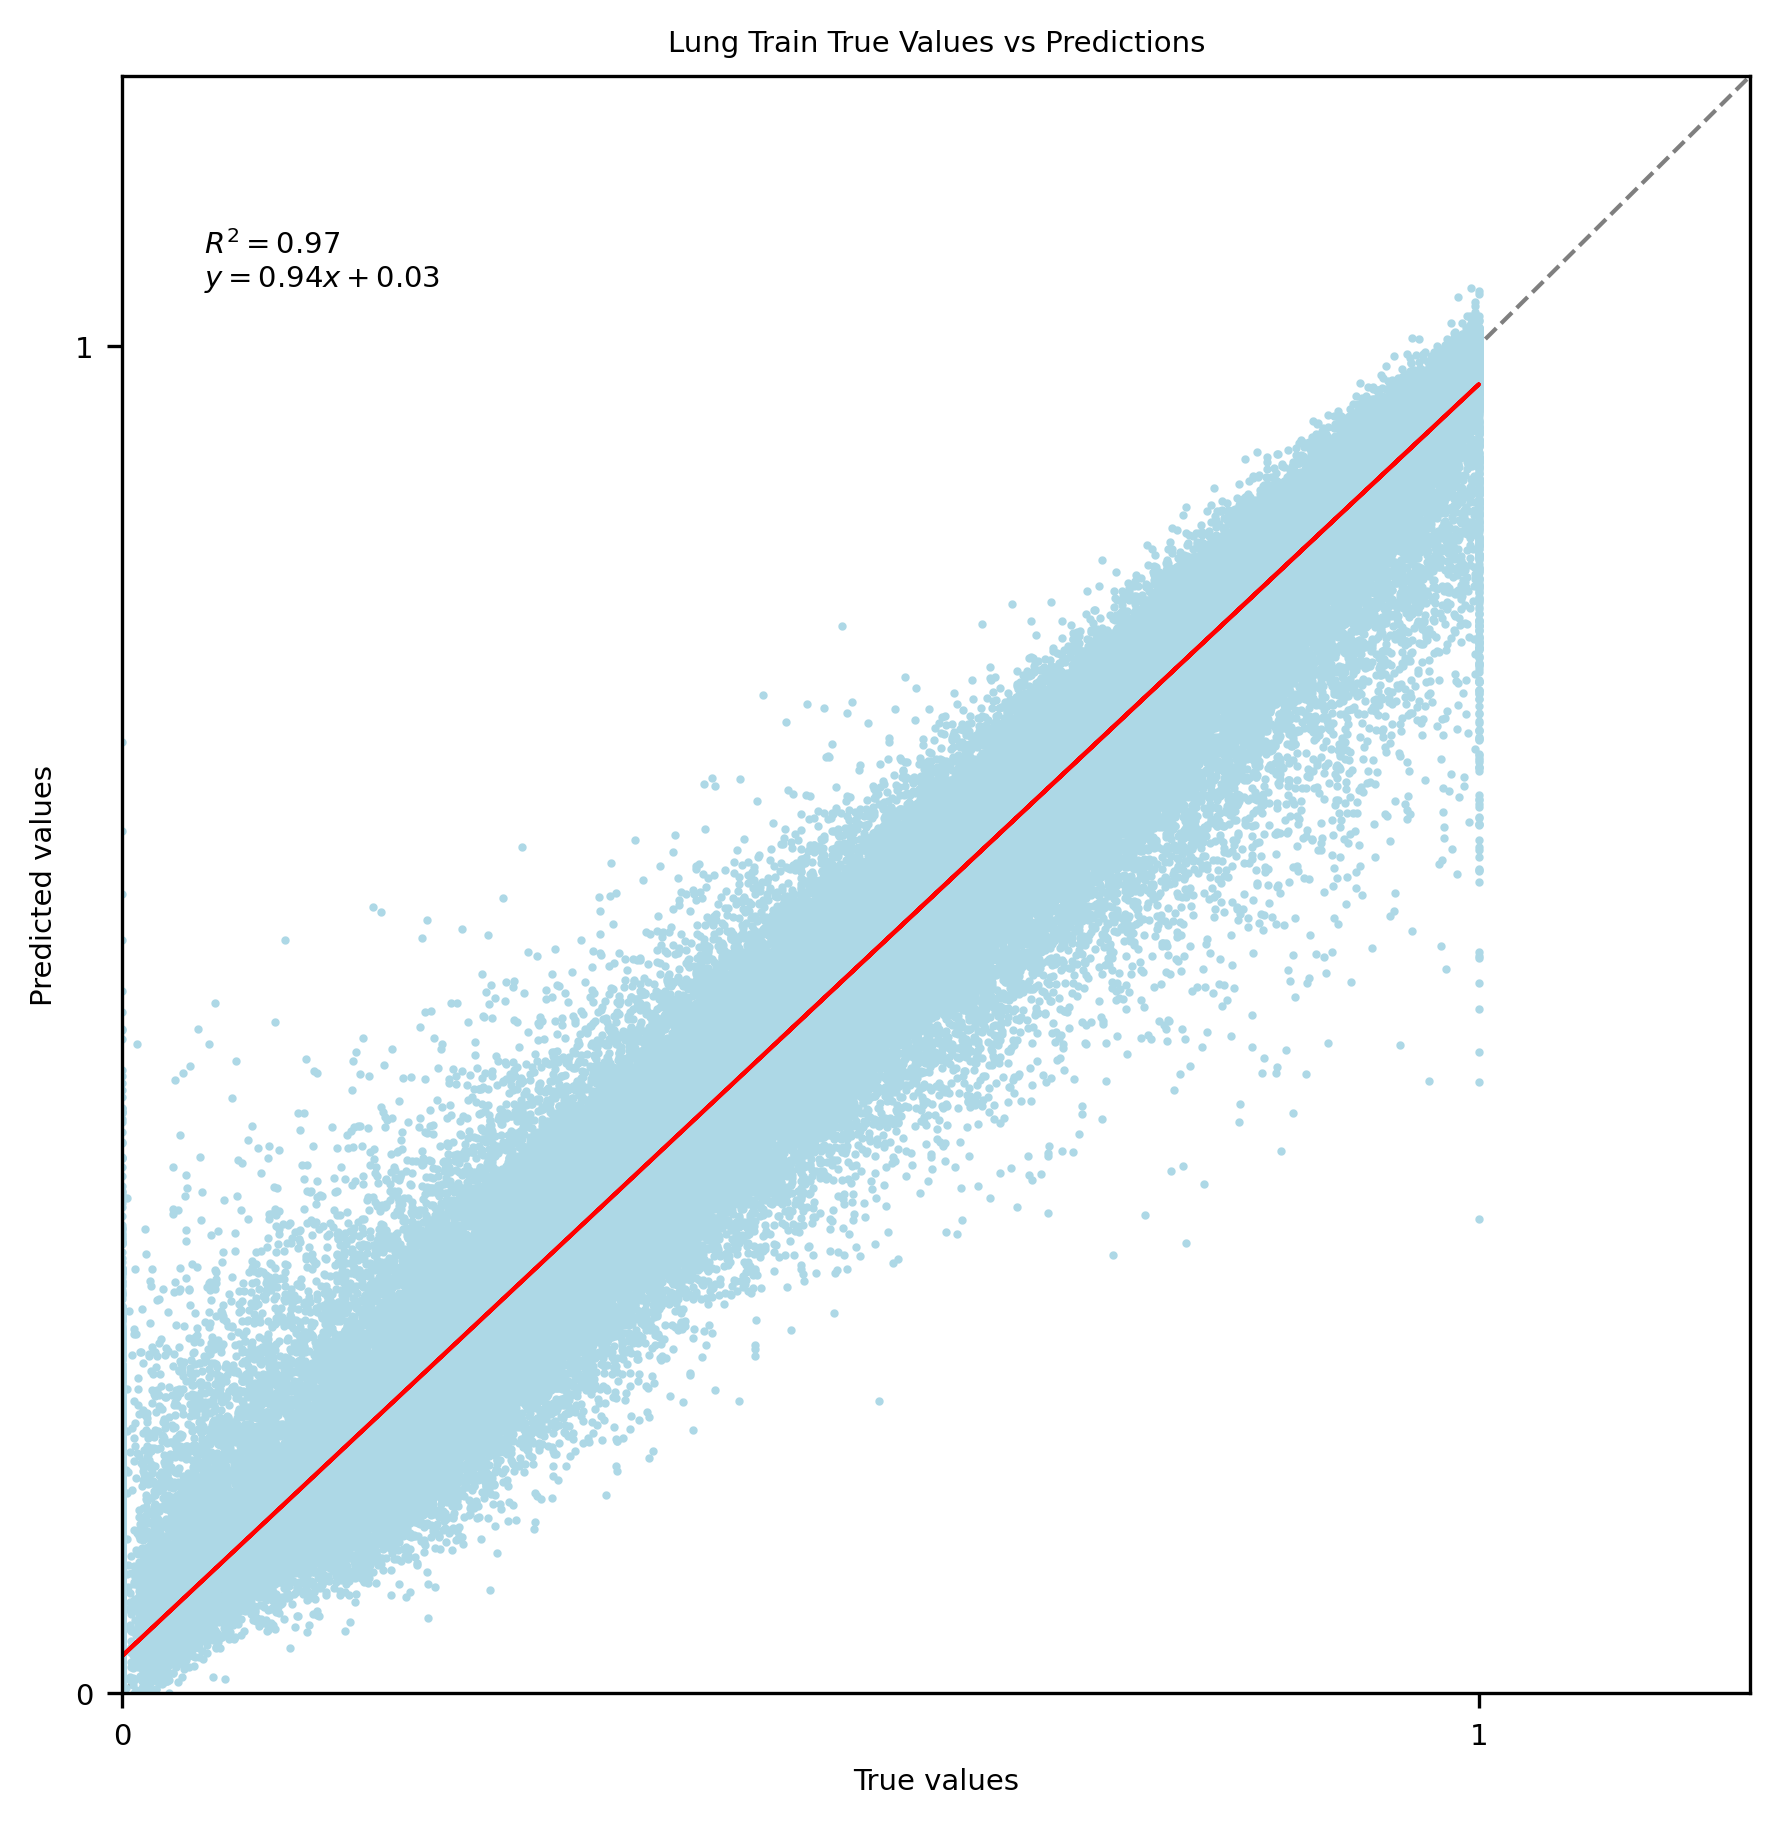

0.8207161176951174


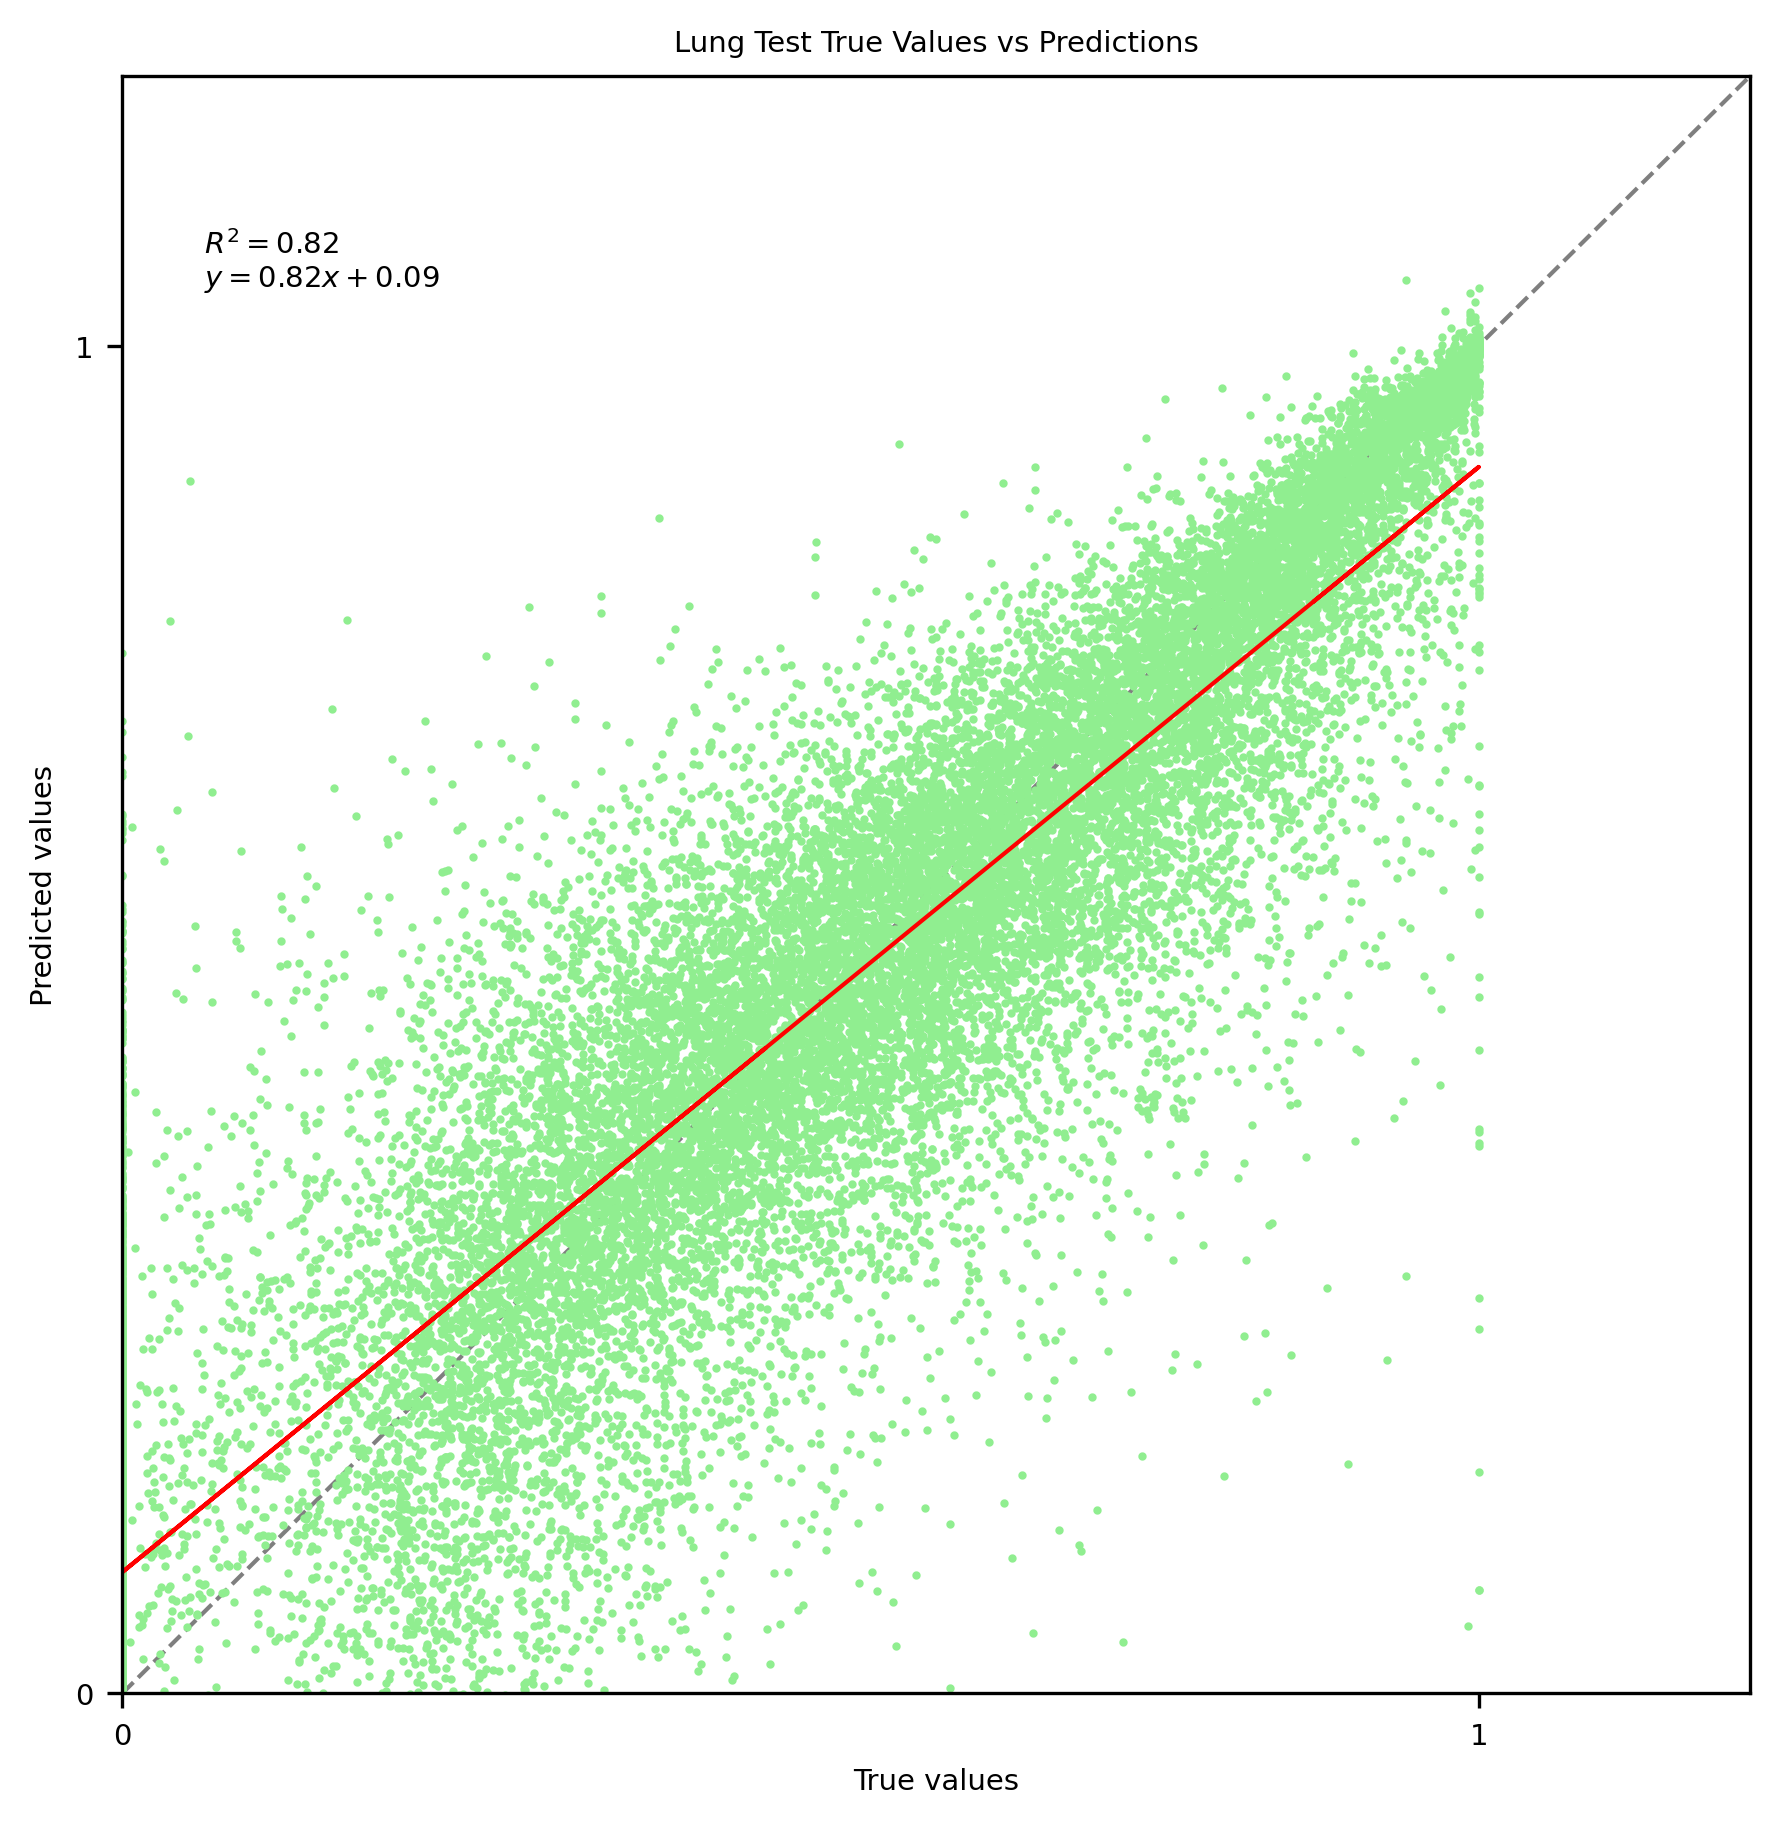

In [16]:
model = Build_Model(lr=0.1,n_estimators=200,max_depth=4)
Train_Model(model,x_train,y_train)

## 预测spatial

In [17]:
st_mrna = pd.read_csv(outdir+cancer+"st_mrna.csv",index_col=0)
st_mirna = model.predict(st_mrna)
st_mirna = pd.DataFrame(st_mirna,index=st_mrna.index,columns=y_train.columns)
st_mirna.to_csv(outdir+"Pre"+cancer+"st_mirna.csv")

In [18]:
st_mirna

,hsa-miR-431,hsa-miR-485,hsa-miR-152,hsa-miR-496,hsa-miR-769,hsa-miR-655,hsa-miR-21,hsa-miR-101,hsa-miR-28,hsa-miR-15b,...,hsa-miR-525,hsa-miR-541,hsa-miR-519e,hsa-miR-24,hsa-miR-302b,hsa-miR-450a,hsa-miR-187,hsa-miR-376a,hsa-miR-26b,hsa-miR-99b
AACACGTGCATCGCAC-1,0.496401,0.520351,0.640309,0.496639,0.502441,0.551026,0.573795,0.541524,0.679207,0.490040,...,0.471559,0.418450,0.419443,0.557375,0.431803,0.560156,0.587661,0.559945,0.489695,0.492857
AACACTTGGCAAGGAA-1,0.388679,0.478916,0.646051,0.435906,0.470886,0.531480,0.539260,0.621108,0.701292,0.533653,...,0.473514,0.409166,0.382021,0.610844,0.382094,0.534382,0.546088,0.545563,0.502018,0.488658
AACAGGATTCATAGTT-1,0.544747,0.490068,0.661416,0.471004,0.530984,0.535493,0.644298,0.542969,0.765931,0.463872,...,0.472744,0.433308,0.375869,0.616906,0.338999,0.494453,0.537927,0.519798,0.541480,0.493201
AACAGGTTATTGCACC-1,0.441857,0.453634,0.582118,0.578092,0.553899,0.497694,0.570959,0.526556,0.701040,0.485192,...,0.517103,0.494440,0.415136,0.550999,0.444260,0.534802,0.578502,0.545357,0.501588,0.581079
AACAGGTTCACCGAAG-1,0.562721,0.472849,0.678196,0.405902,0.499492,0.447041,0.659022,0.559570,0.770671,0.498425,...,0.425568,0.485349,0.433402,0.570856,0.410892,0.515946,0.526767,0.546491,0.510063,0.611591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACCTTCCGC-1,0.516576,0.473939,0.684803,0.423935,0.544770,0.529245,0.556968,0.576586,0.624056,0.500792,...,0.374245,0.507327,0.398329,0.567458,0.337956,0.525170,0.545276,0.500527,0.496296,0.608522
TGTTGGAACGAGGTCA-1,0.464484,0.494546,0.710368,0.522663,0.509720,0.470932,0.498516,0.509462,0.517247,0.564969,...,0.438928,0.417201,0.340648,0.591743,0.447755,0.547172,0.559553,0.568601,0.508879,0.608903
TGTTGGAAGCTCGGTA-1,0.459367,0.467527,0.707605,0.478765,0.483891,0.449084,0.571550,0.571643,0.710130,0.467583,...,0.390811,0.397632,0.459403,0.582110,0.352567,0.509148,0.488174,0.488939,0.522583,0.621387
TGTTGGATGGACTTCT-1,0.477537,0.484050,0.638473,0.514998,0.531530,0.581874,0.517727,0.557891,0.562387,0.535916,...,0.517694,0.456989,0.395424,0.568927,0.442148,0.586308,0.498779,0.611659,0.457738,0.589453
